In [2]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
# CSV imports
base_path = '../Data/f1_dataset/'

races = pd.read_csv(base_path + 'races.csv')
drivers = pd.read_csv(base_path + 'drivers.csv')
qualifying = pd.read_csv(base_path + 'qualifying.csv')
circuits = pd.read_csv(base_path + 'circuits.csv')
constructor_results = pd.read_csv(base_path + 'constructor_results.csv')
constructor_standings = pd.read_csv(base_path + 'constructor_standings.csv')
constructors = pd.read_csv(base_path + 'constructors.csv')
driver_standings = pd.read_csv(base_path + 'driver_standings.csv')
lap_times = pd.read_csv(base_path + 'lap_times.csv')
pit_stops = pd.read_csv(base_path + 'pit_stops.csv')
results = pd.read_csv(base_path + 'results.csv')
seasons = pd.read_csv(base_path + 'seasons.csv')
sprint_results = pd.read_csv(base_path + 'sprint_results.csv')
status = pd.read_csv(base_path + 'status.csv')

In [3]:
# Function to convert the given string in mm:ss:sss format to seconds
def time_to_seconds(t):
    if pd.isna(t): return None
    try:
        m, s = t.split(':')
        return int(m) * 60 + float(s)
    except:
        return None

In [5]:
# Function to convert the given string in mm ss sss format to seconds
def time_to_seconds_1(t):
    if pd.isna(t): return None
    try:
        t = str(t).lower().strip()
        minutes = seconds = milliseconds = 0
        m = re.search(r"(\d+)m", t)
        s = re.search(r"(\d+)s", t)
        ms = re.search(r"(\d+)ms", t)
        if m: minutes = int(m.group(1))
        if s: seconds = int(s.group(1))
        if ms: milliseconds = int(ms.group(1))

        return minutes * 60 + seconds + milliseconds / 1000
    except:
        return None

In [6]:
# Function to convert the given time in seconds to mm:ss:sss format
def seconds_to_time_str(s):
    if s is None: return ''
    m = int(s // 60)
    sec = s % 60
    return f"{m:02}:{sec:06.3f}"

We analyse the best qualifying time for one driver-race combination (Lewis Hamilton - Circuit de Monaco).

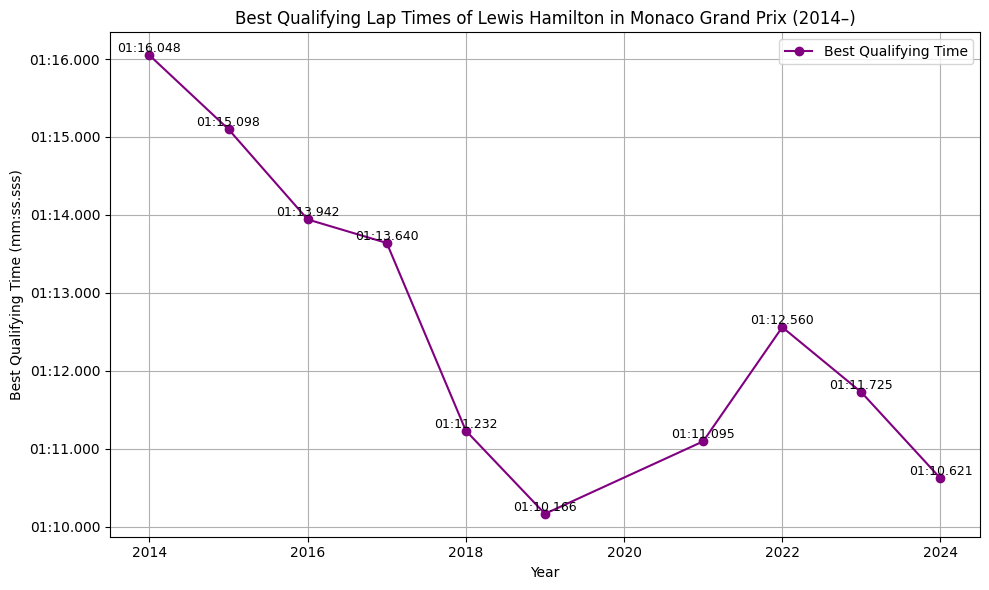

In [46]:
# We are getting the driver_id of Lewis Hamilton (hamilton_id = 1).
hamilton = drivers[drivers['code'] == 'HAM']
hamilton_id = hamilton.iloc[0]['driverId']

# We get the circuit_id for Monaco (monaco_circuit_id = 6). Then we get all the Monaco races after 2014 
# (Hybrid era of F1) and get a list of their race_ids ([ 905  931  953  974  994 1015 1056 1080 1104 1128])
monaco_circuit = circuits[circuits['circuitRef'].str.lower() == 'monaco']
monaco_circuit_id = monaco_circuit.iloc[0]['circuitId']
monaco_races = races[(races['circuitId'] == monaco_circuit_id) & (races['year'] >= 2014)]
monaco_race_ids = monaco_races['raceId'].unique()

# We find the qualifying races of the Monaco circuit driven by Lewis Hamilton
hamilton_qualifying = qualifying[
    (qualifying['driverId'] == hamilton_id) &
    (qualifying['raceId'].isin(monaco_race_ids))
].copy()
hamilton_qualifying = hamilton_qualifying.merge(
    monaco_races[['raceId', 'year']],
    on='raceId',
    how='left'
)

records = []
for _, row in hamilton_qualifying.iterrows():
    times = [time_to_seconds(row.get(session)) for session in ['q1', 'q2', 'q3']]
    times = [t for t in times if t is not None]
    if times:
        best_time = min(times)
        records.append({'year': row['year'], 'best_time': best_time})
    

df = pd.DataFrame(records).drop_duplicates(subset='year').sort_values('year')

# To plot the graph of best qualifying times of Lewis Hamilton in the circuit of Monaco
plt.figure(figsize=(10, 6))
plt.plot(df['year'], df['best_time'], marker='o', color='purple', label='Best Qualifying Time')

for x, y in zip(df['year'], df['best_time']):
    plt.text(x, y, seconds_to_time_str(y), ha='center', va='bottom', fontsize=9)

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: seconds_to_time_str(x)))
plt.title('Best Qualifying Lap Times of Lewis Hamilton in Monaco Grand Prix (2014–)')
plt.xlabel('Year')
plt.ylabel('Best Qualifying Time (mm:ss.sss)')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

We are generating a **year-by-year line plot** of Hamilton’s fastest qualifying lap at Monaco from 2014 onwards — using data from Q1, Q2, and Q3 sessions. 

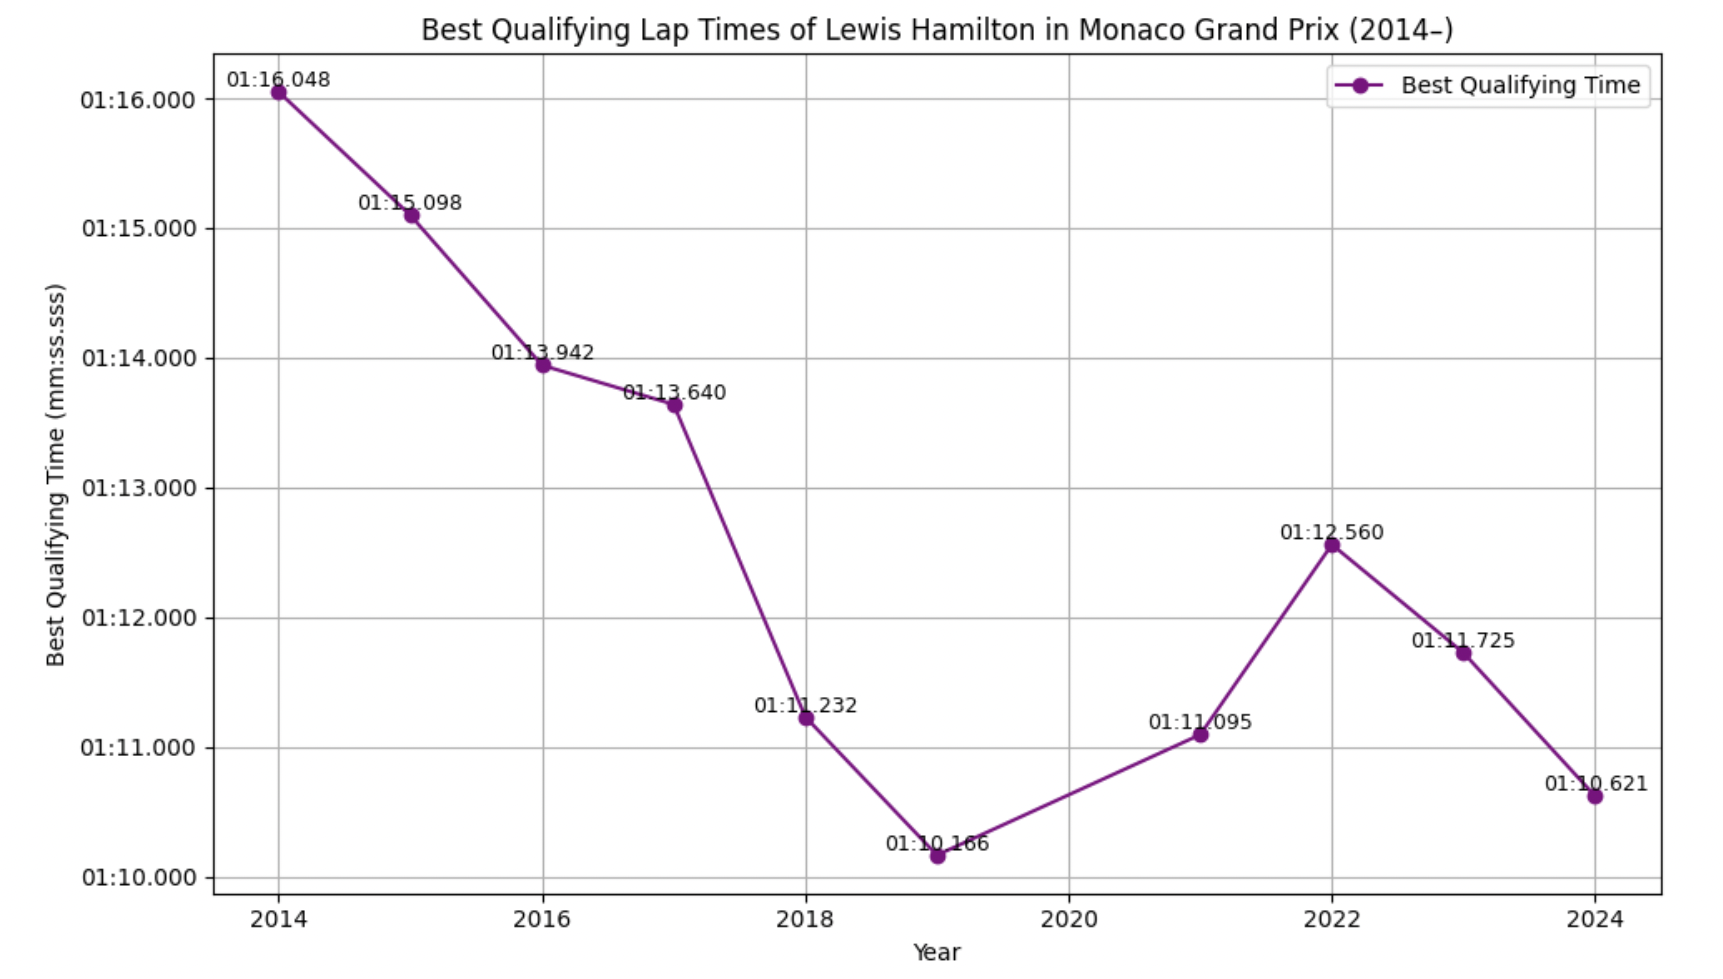

To make our data usefull, we have to sort them into driver - circuit combinations for every driver and circuit avaliable. 
We filter out races so that we are only considering races after the Hybrid Era i.e 2014. 
The fastest lap is the minimum of the Q1, Q2 and Q3 timings as it represents the **fastest raw speed acheivable with minimal interference**. 

We also include the team and teammate data because in F1 drivers move around teammates and teammate timimg is a good metric to judge a driver against. **The teammate is the only driver on the grid with equal machinery.**

In [47]:
races = races[races['year'] >= 2014]

qualifying['q1_seconds'] = qualifying['q1'].apply(time_to_seconds)
qualifying['q2_seconds'] = qualifying['q2'].apply(time_to_seconds)
qualifying['q3_seconds'] = qualifying['q3'].apply(time_to_seconds)
qualifying['fastest_lap'] = qualifying[['q1_seconds', 'q2_seconds', 'q3_seconds']].min(axis=1, skipna=True)

qualifying_with_races = pd.merge(
    qualifying[['raceId', 'driverId', 'constructorId', 'fastest_lap']],
    races[['raceId', 'year', 'circuitId']],
    on='raceId'
)
print(qualifying_with_races.head())

   raceId  driverId  constructorId  fastest_lap  year  circuitId
0     900         1            131       91.699  2014          1
1     900       817              9       90.775  2014          1
2     900         3            131       92.564  2014          1
3     900       825              1       90.949  2014          1
4     900         4              6       91.388  2014          1


This creates a copy of the qualifying_with_races DataFrame but renames two columns: \
'driverId' → 'teammateId' (to represent the teammate’s driver ID)\
'fastest_lap' → 'teammate_fastest_lap' (to represent the teammate’s fastest lap time) 

Then we combine teammate_data with the original qualifying data **for same raceId and constructorId**

In [26]:
teammate_data = qualifying_with_races.rename(columns={
    'driverId': 'teammateId',
    'fastest_lap': 'teammate_fastest_lap'
})
combined = pd.merge(
    qualifying_with_races,
    teammate_data,
    on=['raceId', 'constructorId'],
    suffixes=('', '_teammate')
)
combined = combined[combined['driverId'] != combined['teammateId']] #Removes self joins
teammate_avg = combined.groupby(['raceId', 'driverId'])['teammate_fastest_lap'].mean().reset_index()#if there are multiple teammates

We make a new dataframe which has all the driver, teammate, team data called **full_data**

In [48]:
full_data = pd.merge(
    qualifying_with_races,
    teammate_avg,
    on=['raceId', 'driverId'],
    how='left'
)
full_data = pd.merge(
    full_data,
    drivers[['driverId', 'driverRef', 'forename', 'surname']],
    on='driverId'
)
full_data = pd.merge(
    full_data,
    circuits[['circuitId', 'name']],
    on='circuitId'
)
full_data = full_data.dropna(subset=['fastest_lap'])
full_data['driver_name'] = full_data['forename'] + ' ' + full_data['surname']
full_data['driver_circuit'] = full_data['driver_name'] + ' - ' + full_data['name']
print(full_data.head())

# Filter out combinations with fewer than 3 data points
driver_circuit_counts = full_data['driver_circuit'].value_counts()
valid_combinations = driver_circuit_counts[driver_circuit_counts >= 3].index
full_data = full_data[full_data['driver_circuit'].isin(valid_combinations)]

# Group by driver-circuit combo
driver_circuit_groups = full_data.groupby('driver_circuit')


   raceId  driverId  constructorId  fastest_lap  year  circuitId  \
0     900         1            131       91.699  2014          1   
1     900       817              9       90.775  2014          1   
2     900         3            131       92.564  2014          1   
3     900       825              1       90.949  2014          1   
4     900         4              6       91.388  2014          1   

   teammate_fastest_lap        driverRef  forename    surname  \
0                92.564         hamilton     Lewis   Hamilton   
1                91.931        ricciardo    Daniel  Ricciardo   
2                91.699          rosberg      Nico    Rosberg   
3                91.396  kevin_magnussen     Kevin  Magnussen   
4                92.439           alonso  Fernando     Alonso   

                             name       driver_name  \
0  Albert Park Grand Prix Circuit    Lewis Hamilton   
1  Albert Park Grand Prix Circuit  Daniel Ricciardo   
2  Albert Park Grand Prix Circuit  

The code below exports each unique driver-circuit history (multiple years of data) into its own CSV file. Each file has the teammate fastest lap and constructorId also

In [ ]:
output_dir = '../Data/f1_dataset/driver_circuit_data'
os.makedirs(output_dir, exist_ok=True)

for name, group in driver_circuit_groups:
    group = group.sort_values('year')

    # Clean the filename
    safe_name = re.sub(r'[^a-zA-Z0-9\s]', '', name)
    safe_name = re.sub(r'\s+', '_', safe_name).strip('_')
    filename = f"{output_dir}/{safe_name}.csv"
    
    # Only the required columns
    df = pd.DataFrame({
        'year': group['year'],
        'lap_time_seconds': group['fastest_lap'],
        'teammate_time': group['teammate_fastest_lap'],
        'constructorId': group['constructorId']
    })

    df.to_csv(filename, index=False)

print(f"✅ Saved {len(driver_circuit_groups)} CSVs with only [year, lap_time_seconds, teammate_time, constructorId]")

✅ Saved 621 CSVs with only [year, lap_time_seconds, teammate_time, constructorId]


All the driver - circuit combinations are saved as csv's. For example /driver_circuit_data/Lewis_Hamilton_Circuit_de_Monaco.csv

In [52]:
# To view the file saved for Lewis Hamilton for Monaco
file_path = '/kaggle/working/driver_circuit_data/Lewis_Hamilton_Circuit_de_Monaco.csv'
df = pd.read_csv(file_path)
print("Contents of the file:")
print(df.to_string())

Contents of the file:
   year  lap_time_seconds  teammate_time  constructorId
0  2014            76.048         75.989            131
1  2015            75.098         75.440            131
2  2016            73.942         73.791            131
3  2017            73.640         72.223            131
4  2018            71.232         71.441            131
5  2019            70.166         70.252            131
6  2021            71.095         70.601            131
7  2022            72.560         72.112            131
8  2023            71.725         71.964            131
9  2024            70.621         70.543            131
